<a href="https://colab.research.google.com/github/pranshudatascience/Potato-Plant-Disease-Recogination-System-/blob/main/Potato_Plant_Disease_Identification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

# **Loading Data via Kaggle Api**

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"datasciencepranshu","key":"f206fef76574e388b3dba86a1861be62"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

**Kaggle API command**

In [5]:
!kaggle datasets download -d emmarex/plantdisease

 99% 651M/658M [00:15<00:00, 32.6MB/s]
100% 658M/658M [00:15<00:00, 44.6MB/s]


In [6]:
from zipfile import ZipFile
file_name = "plantdisease.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [8]:
#Give dataset path
train_path = '/content/Plant Disease'


In [9]:
folders = glob('/content/Plant Disease/*')
len(folders)

3

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **Designing our Model**

In [11]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

234561536/234545216 [==============================] - 7s 0us/step


In [12]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=3, activation='softmax')(x)
model = Model(ResNet_model.input, output)


model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

# **Image Augmentation**

In [14]:
# Use the Image Data Generator to import the images from the dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)  # val 20%

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
#no flip and zoom for test dataset

In [15]:
# Make sure you provide the same target size as initialied for the image size

training_set = train_datagen.flow_from_directory('/content/Plant Disease',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 subset = 'training')

Found 1722 images belonging to 3 classes.


In [16]:

test_set = test_datagen.flow_from_directory('/content/Plant Disease',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            subset = 'validation')

Found 430 images belonging to 3 classes.


In [17]:
training_set.class_indices

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

In [19]:
class_names= training_set.class_indices
class_names ={value:key for key, value in class_names.items()}
print(class_names)


{0: 'Potato___Early_blight', 1: 'Potato___Late_blight', 2: 'Potato___healthy'}


# **Training Our Model**

In [21]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
54/54 [==============================] - 83s 806ms/step - loss: 0.2957 - accuracy: 0.8972 - val_loss: 3.1930 - val_accuracy: 0.9116
Epoch 2/10
54/54 [==============================] - 38s 707ms/step - loss: 0.1537 - accuracy: 0.9576 - val_loss: 0.7807 - val_accuracy: 0.9372
Epoch 3/10
54/54 [==============================] - 38s 706ms/step - loss: 0.0606 - accuracy: 0.9779 - val_loss: 0.1890 - val_accuracy: 0.9721
Epoch 4/10
54/54 [==============================] - 38s 707ms/step - loss: 0.0621 - accuracy: 0.9832 - val_loss: 0.2860 - val_accuracy: 0.9558
Epoch 5/10
54/54 [==============================] - 38s 703ms/step - loss: 0.0840 - accuracy: 0.9739 - val_loss: 0.0819 - val_accuracy: 0.9884
Epoch 6/10
54/54 [==============================] - 38s 700ms/step - loss: 0.0735 - accuracy: 0.9779 - val_loss: 0.0900 - val_accuracy: 0.9837
Epoch 7/10
54/54 [==============================] - 38s 703ms/step - loss: 0.0676 - accuracy: 0.9843 - val_loss: 0.4898 - val_accuracy: 0.9628

# **Plotting about Loss and Accuracy**

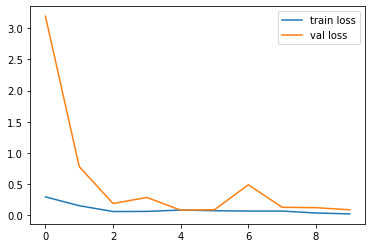

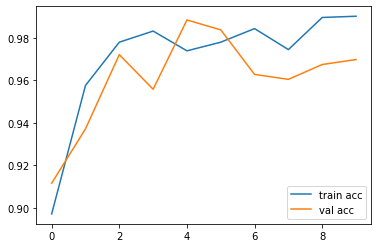

<Figure size 432x288 with 0 Axes>

In [22]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [24]:
from tensorflow.keras.models import load_model

model.save('modelpotato_resNet.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [25]:
y_pred = model.predict(test_set)

# **Making Predictions**

In [26]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([2, 0, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 1, 2, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       2, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0,
       1, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,

In [27]:
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score

# **Making Predictions by giving input manually**

In [31]:
def predict_image(img):
    plt.figure(figsize=(40,8))
    print()
    print('----------------------------------Potato Disease Identiffication----------------------------------------')
    print('----------------------------------------THE PREDICTION:-----------------------------------')
    print()
    x=image.img_to_array(img)
    x=x/255
    plt.imshow(img)
    x=np.expand_dims(x,axis=0)
    #img_data=preprocess_input(x)

    print(class_names[np.argmax(model.predict(x))])


----------------------------------Potato Disease Identiffication----------------------------------------
----------------------------------------THE PREDICTION:-----------------------------------

Potato___Early_blight


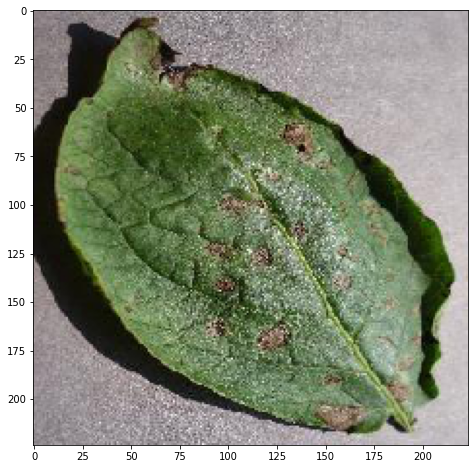

In [32]:
im=image.load_img('/content/Plant Disease/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG',target_size=(224,224))
predict_image(im)


----------------------------------Potato Disease Identiffication----------------------------------------
----------------------------------------THE PREDICTION:-----------------------------------

Potato___Early_blight


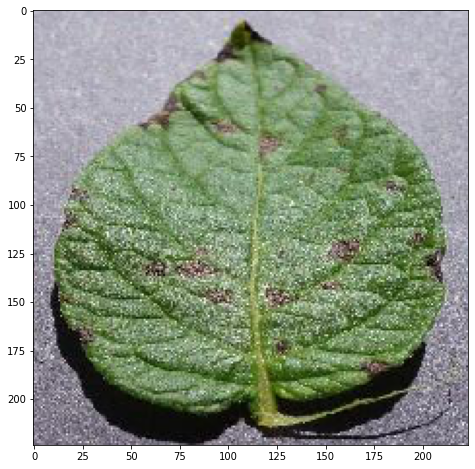

In [33]:
im3=image.load_img('/content/Plant Disease/Potato___Early_blight/048d18ae-98b1-484d-97da-5a0e69b9ebc1___RS_Early.B 6845.JPG',target_size=(224,224))
predict_image(im3)


----------------------------------Potato Disease Identiffication----------------------------------------
----------------------------------------THE PREDICTION:-----------------------------------

Potato___Late_blight


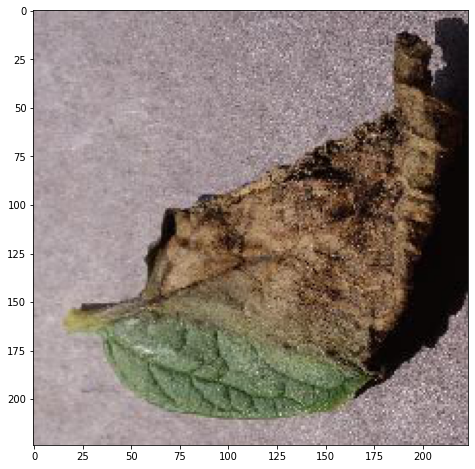

In [34]:
im4=image.load_img('/content/plantvillage/PlantVillage/Potato___Late_blight/0114b195-844c-4978-93a9-b0d5aae010f1___RS_LB 2738.JPG',target_size=(224,224))
predict_image(im4)


----------------------------------Potato Disease Identiffication----------------------------------------
----------------------------------------THE PREDICTION:-----------------------------------

Potato___Late_blight


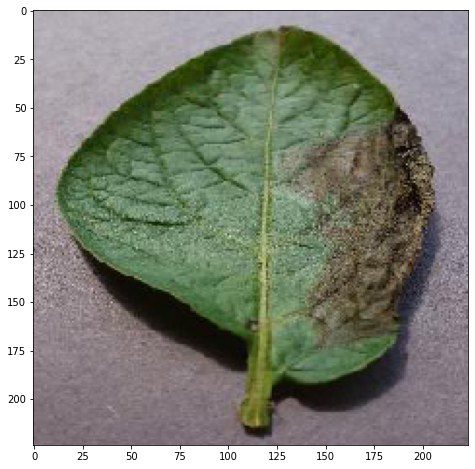

In [35]:
im5=image.load_img('/content/plantvillage/PlantVillage/Potato___Late_blight/01a8cc9f-074a-4866-87c8-bb5a9e3895b4___RS_LB 2968.JPG',target_size=(224,224))
predict_image(im5)


----------------------------------Potato Disease Identiffication----------------------------------------
----------------------------------------THE PREDICTION:-----------------------------------

Potato___Late_blight


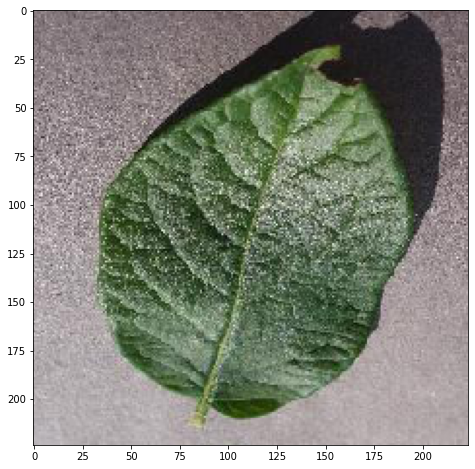

In [36]:
im6=image.load_img('/content/plantvillage/PlantVillage/Potato___healthy/07dfb451-4378-49d1-b699-33a5fc49ff07___RS_HL 5399.JPG',target_size=(224,224))
predict_image(im6)


----------------------------------Potato Disease Identiffication----------------------------------------
----------------------------------------THE PREDICTION:-----------------------------------

Potato___healthy


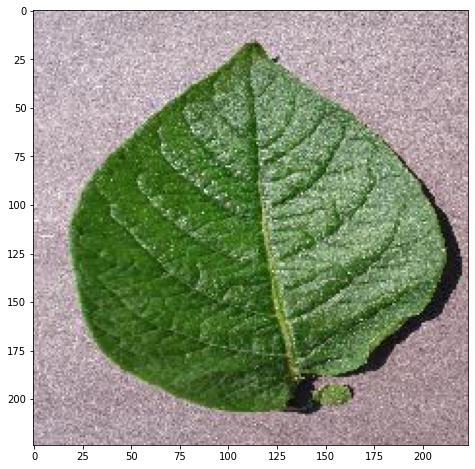

In [37]:
im7=image.load_img('/content/plantvillage/PlantVillage/Potato___healthy/31a09d39-6791-4ecb-8f44-af2ed85dbd33___RS_HL 1970.JPG',target_size=(224,224))
predict_image(im7)


----------------------------------Potato Disease Identiffication----------------------------------------
----------------------------------------THE PREDICTION:-----------------------------------

Potato___healthy


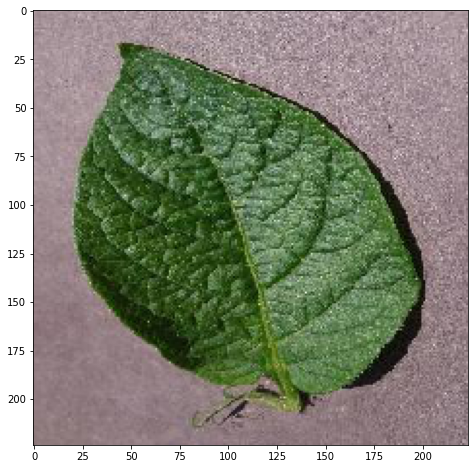

In [38]:
im8=image.load_img('/content/plantvillage/PlantVillage/Potato___healthy/30126310-39de-4c02-b10a-23409417a4f6___RS_HL 1826.JPG',target_size=(224,224))
predict_image(im8)


----------------------------------Potato Disease Identiffication----------------------------------------
----------------------------------------THE PREDICTION:-----------------------------------

Potato___Late_blight


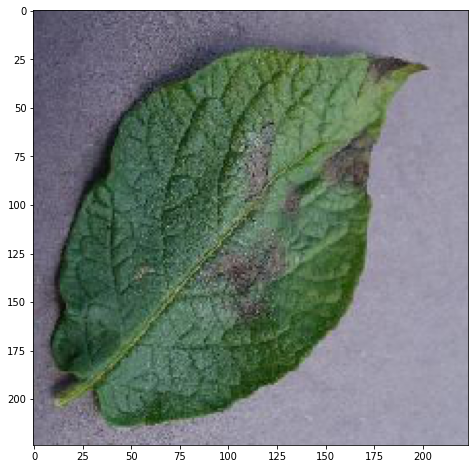

In [39]:
im9=image.load_img('/content/plantvillage/PlantVillage/Potato___Late_blight/031672c9-bf0a-46bf-8b52-d7cdc067612e___RS_LB 5019.JPG',target_size=(224,224))
predict_image(im9)


----------------------------------Potato Disease Identiffication----------------------------------------
----------------------------------------THE PREDICTION:-----------------------------------

Potato___Early_blight


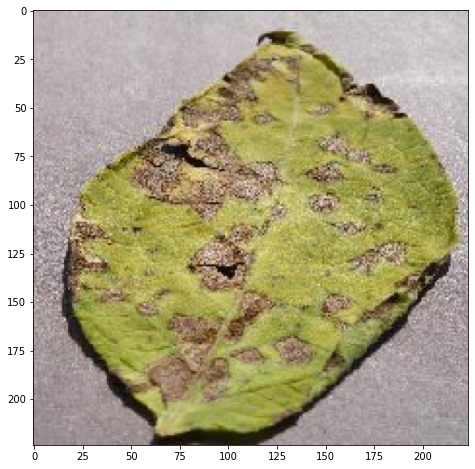

In [40]:
im10=image.load_img('/content/plantvillage/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG',target_size=(224,224))
predict_image(im10)